In [2]:
import geopandas
from shapely import geometry
import matplotlib.pyplot as plt
from scipy.spatial import (
    Voronoi,
    voronoi_plot_2d,
    Delaunay,
    delaunay_plot_2d,
    cKDTree
)
import numpy as np
import math, time
import interpolators

mode = "raw"

def getMeasurementValue(value):
    if math.isnan(value):
        return 0

    if mode == "raw":
        return value

    if mode == "int":
        return int(value)

    zones = [[0, 20], [20, 40], [40, 60], [60, math.inf]]
    for i, zone in enumerate(zones):
        zoneMin, zoneMax = zone
        if value >= zoneMin and value < zoneMax:
            return zoneMin

def getPolygonsFromContour(contour):
    polygons = []
    for col in contour.collections:
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths():
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for idx, poly_coords in enumerate(contour_path.to_polygons()):
                x = poly_coords[:, 0]
                y = poly_coords[:, 1]

                new_shape = geometry.Polygon(
                    [(point[0], point[1]) for point in zip(x, y)]
                )
                if idx == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings

            polygons.append(poly)
    return polygons

external_crs = "EPSG:4326"
internal_crs = "EPSG:3068"
berlinDistricts = geopandas.read_file("../shared/berlinDistricts.geojson")
measurements = geopandas.read_file("test/data_2020-02-20T14-00-00.geojson")

berlinDistricts = berlinDistricts.to_crs(internal_crs)
measurements = measurements.to_crs(internal_crs)

x = np.array(measurements.geometry.x)
y = np.array(measurements.geometry.y)
values = np.array(measurements.value)
points = np.column_stack((x, y))

xmin, ymin, xmax, ymax = measurements.total_bounds
size = 500  # grid cell size in meters
xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))

In [ ]:
# Plot Berlin Boundaries with Measurements

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Measurements")
berlinPlot = berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
measurements.plot(ax=ax, column="value", legend=True)

In [ ]:
# Plot Berlin boundaries with interpolation grid

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Interpolation Grid")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
xx, yy = np.meshgrid(xnew,ynew)
ax.scatter(xx, yy, s=1)

In [ ]:
# Plot Berlin with Voronoi diagram

voronoi = Voronoi(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Voronoi Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
voronoi_plot_2d(voronoi, ax=ax, show_vertices=False, show_points=True, line_colors='orange')

In [ ]:
# Plot Berlin with Delauny diagram

delauny = Delaunay(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Delauny Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
delaunay_plot_2d(delauny, ax=ax)

In [59]:
print(np.array(list(zip(points[:,0], points[:, 1], values))).shape)

(431, 3)


In [6]:
import collections, random
from scipy import interpolate
from scipy.spatial.distance import cdist

from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

def ordinary_kriging(x, y, points, value): 
    
    ok_interpolator = OrdinaryKriging(points[:, 0], points[:, 1], values, variogram_model='gaussian',
                     verbose=True, enable_plotting=True)
    xx, yy = np.meshgrid(x, y)
    result = ok_interpolator.execute('grid', x, y)
    print(result[0])
    print(np.min(result[0]))
    print(np.max(result[0]))
    return result[0]

def spline(x, y, points, values):
    xx, yy = np.meshgrid(x, y)
    point_matrix = np.dstack((xx, yy))
    tck = interpolate.bisplrep(points[:,0], points[:,1], values)
    grid_values = interpolate.bisplev(xnew, ynew, tck).T
    print(grid_values.shape)
    return grid_values

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from geostatsmodels import utilities, kriging, variograms, model, geoplot
from geostatsmodels.kriging import krige
from scipy.stats import norm
def kriging(x, y, points, values):
    gpr = GaussianProcessRegressor(normalize_y=True)
    gpr.fit(points, values)

    xx, yy = np.meshgrid(x, y)
    new_points = np.column_stack([xx.flatten(), yy.flatten()])
    result = gpr.predict(new_points)
    print(new_points.shape)
    print(np.min(result))
    print(np.max(result))
    # return result.reshape(y.shape[0], x.shape[0])


    x_point_dup = [
        item for item, count in collections.Counter(points[:, 0]).items() if count > 1
    ]
    y_point_dup = [
        item for item, count in collections.Counter(points[:, 1]).items() if count > 1
    ]
    fixed_x = list(
        map(
            lambda x: x + random.uniform(-0.00001, 0.00001) if x in x_point_dup else x,
            points[:, 0],
        )
    )
    fixed_y = list(
        map(
            lambda y: y + random.uniform(-0.00001, 0.00001) if y in y_point_dup else y,
            points[:, 1],
        )
    )

    fixed_points = np.column_stack((fixed_x, fixed_y))


    tolerance = 250
    lags = np.arange(tolerance, 10000, tolerance*2)
    sill = np.var(values)
    P = np.array(list(zip(fixed_points[:,0], fixed_points[:, 1], values)))
    # geoplot.semivariogram(P, lags, tolerance)
    svm = model.semivariance(model.spherical, (4000, sill))
    # geoplot.semivariogram(P, lags, tolerance, model=svm)
    covfct = model.covariance(model.spherical, (4000, sill))
    # kriging.simple(P, covfct, pt, N=6)
    est, kstd = krige(P, covfct, new_points, 'simple', N=6)


def inverse_distance_weighting(x, y, points, values, p=2, k=6, grid=False):
    # Credits to this guy: https://github.com/paulbrodersen/inverse_distance_weighting/blob/master/idw.py
    tree = cKDTree(points, leafsize=10)
    eps = 1e-6
    regularize_by = 1e-9

    if grid:
        grid = np.meshgrid(x, y)
        point_matrix = np.reshape(grid, (2, -1)).T
    else:
        point_matrix = np.column_stack((x, y))
    print(point_matrix)

    distances, idx = tree.query(point_matrix, k, eps=eps, p=p)

    if len(idx.shape) == 1:
        distances = np.atleast_2d(distances).reshape((-1, 1))
        idx = np.atleast_2d(idx).reshape((-1, 1))

    distances += regularize_by
    neighbor_values = values[idx.ravel()].reshape(idx.shape)
    summed_inverse_distances = np.sum(1 / distances, axis=1)
    idw_values = np.sum(neighbor_values / distances, axis=1) / summed_inverse_distances
    return idw_values.reshape(grid[0].shape)


start = time.time()

# interpolated_values = interpolators.nearest_neighbor(xnew, ynew, points, values)
interpolated_values = inverse_distance_weighting(xnew, ynew, points, values)
# interpolated_values = rbf(xnew, ynew, points, values)
# interpolated_values = kriging(xnew, ynew, points, values)
# interpolated_values = interpolators.linear_barycentric(xnew, ynew, points, values)
# interpolated_values = interpolators.natural_neighbor(xnew, ynew, points, values)
# interpolated_values = interpolators.discrete_natural_neighbor(xnew, ynew, points, values)
# interpolated_values = interpolators.inverse_distance_weighting(xnew, ynew, points, values, k=10)

# interpolated_values = np.array([list(map(getMeasurementValue, row)) for row in interpolated_values])

# print(interpolated_values.shape)

end = time.time()
print(end - start)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 182 and the array at index 1 has size 125

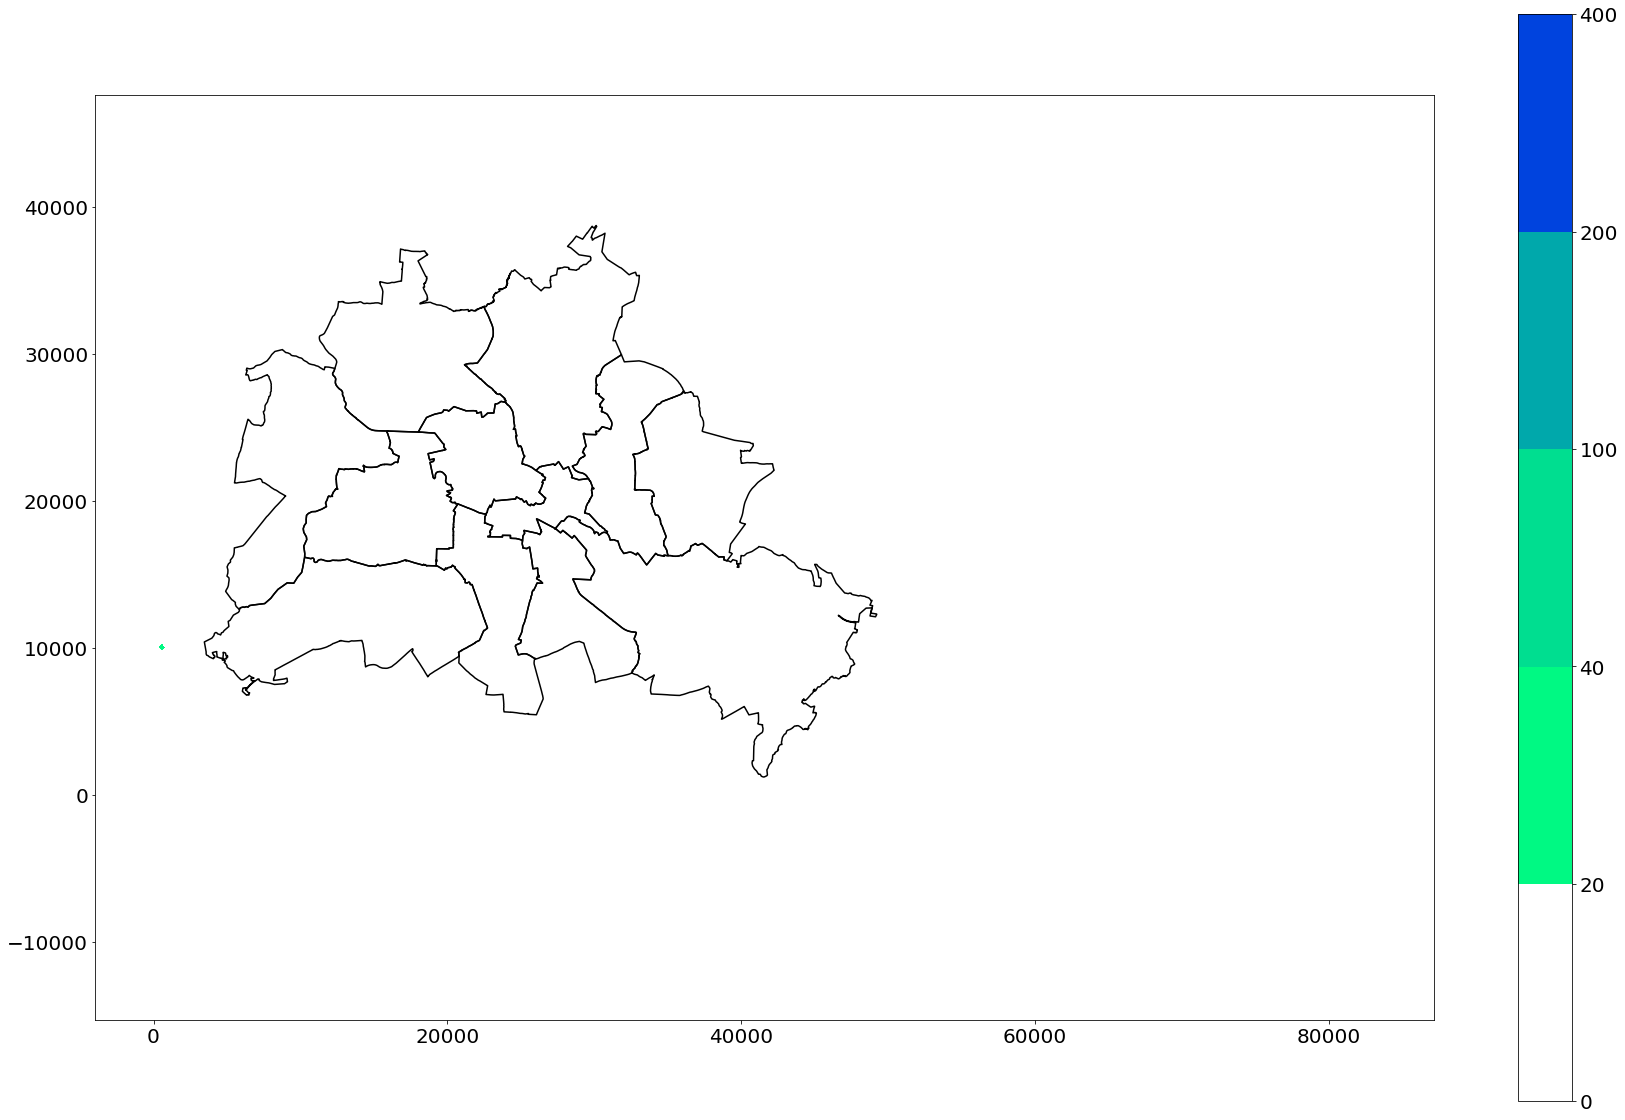

In [10]:
plt.rcParams["figure.figsize"] = 30, 20
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

fig, ax = plt.subplots()

berlinDistricts.boundary.plot(ax=ax, edgecolor="black")

n_zones = 4
zones = [0,20,40,100,200,400]
plot = ax.contourf(xnew, ynew, interpolated_values, zones, cmap="winter_r")
plot.cmap.set_under('w')
plot.set_clim(zones[1])

# plot = ax.pcolormesh(xnew, ynew, interpolated_values)


fig.colorbar(plot, ax=ax)
# plt.show()

# plt.savefig("nn2.png")


In [ ]:
polygons = getPolygonsFromContour(plot)[1:] # skip first because it covers all areas with zones as holes
polygons = geopandas.GeoSeries(polygons)
polygons.crs = internal_crs
polygons = polygons.to_crs(external_crs)
polygons.to_file("test.geojson", driver="GeoJSON")

In [ ]:
import geopandas
from shapely import geometry
import matplotlib.pyplot as plt
from scipy.spatial import (
    Voronoi,
    voronoi_plot_2d,
    Delaunay,
    delaunay_plot_2d,
    cKDTree
)
import numpy as np
import math, time
import interpolators

measurements = geopandas.read_file("test/data_2020-02-20T00-30-00.geojson")
measurements = geopandas.read_file("test/data_2020-02-20T01-00-00.geojson")
np.sort(measurements.value)

In [22]:
import matplotlib
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis', 4)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    # print(matplotlib.colors.rgb2hex(rgb))
    print(",".join(list(map(str,rgb))))

0.267004,0.004874,0.329415
0.190631,0.407061,0.556089
0.20803,0.718701,0.472873
0.993248,0.906157,0.143936
